# Testing diffusion problem format

Grid and parameters

In [69]:
using Plots

In [98]:
struct Grid
    xmax::Float64
    ymax::Float64

    nx::Int64
    ny::Int64
    
    Δx::Float64
    Δy::Float64

    xRange::Array{Float64,1}
    yRange::Array{Float64,1}

    function Grid(xmax, ymax, nx, ny)
        Δx = 2*xmax/(nx-1)
        Δy = 2*ymax/(ny-1)

        xRange = (-xmax:Δx:xmax)
        yRange = (-ymax:Δy:ymax)

        return new(xmax, ymax, nx, ny, Δx, Δy, xRange, yRange)
    end
end
struct Parameters
    ν::Float64
    σ::Float64
    tspan::Tuple{Float64,Float64}
end

Model setup

In [99]:
abstract type FluidModel end
mutable struct DiffusionModel{T<:Union{Function,Nothing}} <: FluidModel
    u0::Array{Float64,2}
    u_analytic::T
    
    grid::Grid
    parameters::Parameters
    
    Δt::Float64
    t::Array{Float64,1}
    
    function DiffusionModel(u0, u_analytic::T, grid, parameters) where T<:Union{Function,Nothing}
        Δt = parameters.σ*grid.Δx*grid.Δy/parameters.ν
        t = parameters.tspan[1]:Δt:parameters.tspan[2]
        return new{T}(u0, u_analytic, grid, parameters, Δt ,t)
    end
end
DiffusionModel(grid, parameters) = DiffusionModel(zeros(grid.ny, grid.nx), nothing, grid, parameters)
DiffusionModel(u0, grid, parameters) = DiffusionModel(u0, nothing, grid, parameters);

Test setup of model

In [100]:
function make_gaussian(grid::Grid)
    u0 = zeros(grid.ny, grid.nx)
    x = grid.xRange
    y = grid.yRange
    
    x₀ = 0.0
    y₀ = 0.0
    var₀ = 0.1
    T₀ = 1.0
    for j = 1 : grid.ny, i = 1 : grid.nx
        u0[j,i] = T₀*exp(-((x[i]-x₀)^2 + (y[j]-y₀)^2)/var₀)
    end
    return u0
end
function solution_gaussian(grid::Grid, t, κ)
    uana = zeros(grid.ny, grid.nx)
    x = grid.xRange
    y = grid.yRange
    
    x₀ = 0.0
    y₀ = 0.0
    var₀ = 0.1
    T₀ = 1.0
    
    for j = 1 : grid.ny, i = 1 : grid.nx
        uana[j,i] = T₀/sqrt(1+4*κ*t/var₀)*
                exp(-((x[i]-x₀)^2 + (y[j]-y₀)^2)/(var₀+4*κ*t))
    end
    return uana
end;

In [101]:
grid_test = Grid(1., 2., 16, 32)
param_test = Parameters(0.2, 0.00025, (0.0, 0.05))
u0_test = make_gaussian(grid_test)
uana_test(t) = solution_gaussian(grid_test, t, param_test.ν)

mod_test = DiffusionModel(u0_test, uana_test, grid_test, param_test)
#mod_test = DiffusionModel(u0_test, grid_test, param_test)
dump(mod_test)

DiffusionModel{typeof(uana_test)}
  u0: Array{Float64}((32, 16)) [1.9287498479639178e-22 2.3237350855472416e-21 … 2.3237350855472416e-21 1.9287498479639178e-22; 2.847663821131231e-20 3.4308318105593745e-19 … 3.4308318105593745e-19 2.847663821131231e-20; … ; 2.847663821131231e-20 3.4308318105593745e-19 … 3.4308318105593745e-19 2.847663821131231e-20; 1.9287498479639178e-22 2.3237350855472416e-21 … 2.3237350855472416e-21 1.9287498479639178e-22]
  u_analytic: uana_test (function of type typeof(uana_test))
  grid: Grid
    xmax: Float64 1.0
    ymax: Float64 2.0
    nx: Int64 16
    ny: Int64 32
    Δx: Float64 0.13333333333333333
    Δy: Float64 0.12903225806451613
    xRange: Array{Float64}((16,)) [-1.0, -0.8666666666666667, -0.7333333333333333, -0.6, -0.4666666666666667, -0.3333333333333333, -0.2, -0.06666666666666667, 0.06666666666666667, 0.2, 0.3333333333333333, 0.4666666666666667, 0.6, 0.7333333333333333, 0.8666666666666667, 1.0]
    yRange: Array{Float64}((32,)) [-2.0, -1.87096774193

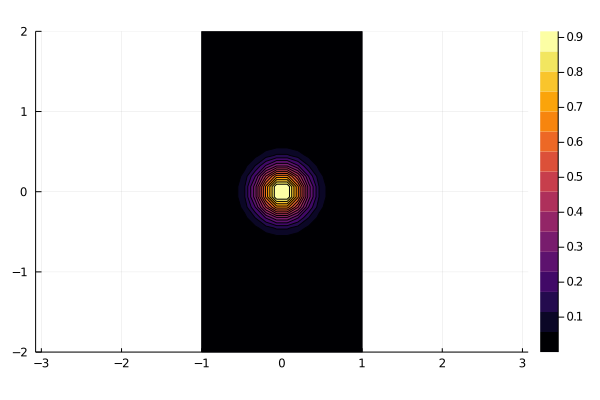

In [102]:
contourf(grid_test.xRange, grid_test.yRange, u0_test, aspect_ratio=:equal)

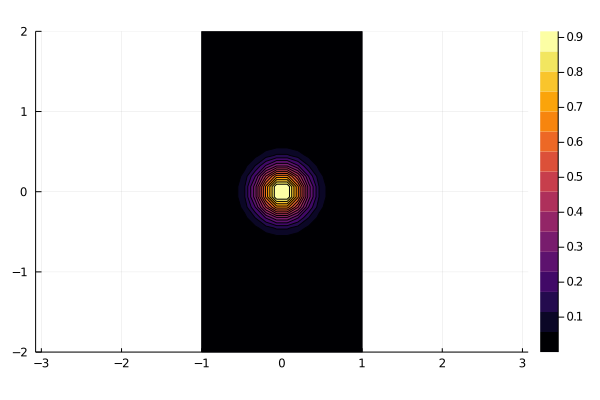

In [103]:
contourf(grid_test.xRange, grid_test.yRange, uana_test(0.0), aspect_ratio=:equal)

# Solving methods

1. Cache

In [104]:
abstract type DiffusionCache end
mutable struct ExplicitDiffusionCache <: DiffusionCache
    u::Array{Float64,2}
    uprev::Array{Float64,2}
    t::Float64
end
mutable struct CNDiffusionCache <: DiffusionCache
    u::Array{Float64,2}
    uprev::Array{Float64,2}
    rhs::Array{Float64,2}
    a1::Array{Float64,2}
    a2::Array{Float64,2}
    t::Float64
end
mutable struct ADIDiffusionCache <: DiffusionCache
    u::Array{Float64,2}
    uhalf::Array{Float64,2}
    uprev::Array{Float64,2}
    rhs::Array{Float64,2}
    a1x::Array{Float64,2}
    a1y::Array{Float64,2}
    a2x::Array{Float64,2}
    a2y::Array{Float64,2}
    t::Float64
end

Methods

In [105]:
abstract type DiffusionMethod end
struct ExplicitDiffusion <: DiffusionMethod end
struct CrankNickolsonDiffusion <: DiffusionMethod end
struct ADIDiffusion <: DiffusionMethod end

In [106]:
function perform_step!(model::DiffusionModel, method::ExplicitDiffusion, cache::ExplicitDiffusionCache)
    u  = cache.u
    un = cache.uprev
    nx = model.grid.nx
    ny = model.grid.ny
    Δx = model.grid.Δx
    Δy = model.grid.Δy
    Δt = model.Δt
    ν  = model.parameters.ν
    
    copy!(un,u)
    @inbounds for j in 2:ny-1, i in 2:nx-1
        u[j,i] = un[j,i] + 
            ν*Δt/(Δx*Δx)*(un[j  ,i+1]-2*un[j,i]+un[j  ,i-1]) + 
            ν*Δt/(Δy*Δy)*(un[j+1,i  ]-2*un[j,i]+un[j-1,i  ])
    end
    
    return nothing
end
function perform_step!(model::DiffusionModel, method::CrankNickolsonDiffusion, cache::CNDiffusionCache)
    u   = cache.u
    un  = cache.uprev
    rhs = cache.rhs
    a1  = cache.a1
    a2  = cache.a2
    
    copy!(un,u)
    
    unV = @view un[2:end-1,2:end-1]
    unVC = @view unV[:]
    uV = @view u[2:end-1,2:end-1]
    uVC = @view uV[:]
    rhsV = @view rhs[2:end-1,2:end-1]
    rhsVC = @view rhsV[:]

    mul!(rhsVC, a2, unVC)
    uVC .= a1\rhsV[:]

    return nothing
end
function perform_step!(model::DiffusionModel, method::ADIDiffusion, cache::ADIDiffusionCache)
    u   = cache.u
    uhalf = cache.uprev
    un  = cache.uprev
    rhs = cache.rhs
    a1  = cache.a1
    a2  = cache.a2
    
    copy!(un,u)
  
    un_i(i) = @view un[2:end-1,i]
    u_i(i) = @view u[2:end-1,i]
    rhs_j(j) = @view rhs[j,2:end-1]
    rhs_i(i) = @view rhs[2:end-1,i]
    uhalf_j(j) = @view uhalf[j,2:end-1]

    # Step one
    for i = 2:nx-1
        mul!(rhs_i(i), a2y, un_i(i))
    end
    for j = 2:ny-1
        ldiv!(uhalf_j(j), a1x, rhs_j(j))
    end

    # Step two
    for j = 2:ny-1
        mul!(rhs_j(j), a2x, uhalf_j(j))
    end
    for i = 2:nx-1
        ldiv!(u_i(i), a1y, rhs_i(i))
    end
    return nothing
end
function apply_BCs!(cache)
    u = cache.u
    u[1,:]   .= 0.0
    u[end,:] .= 0.0
    u[:,1]   .= 0.0
    u[:,end] .= 0.0
    return nothing
end;

In [107]:
# Cache initialisers
init_cache(model, method::ExplicitDiffusion) = 
    ExplicitDiffusionCache(copy(model.u0), copy(model.u0), copy(mod_test.parameters.tspan[1]))
function init_cache(model, method::CrankNickolsonDiffusion)
    u     = copy(model.u0)
    uprev = copy(model.u0)
    rhs   = copy(model.u0)
    
    a1, a2 = init_CN(model)
    
    t = copy(mod_test.parameters.tspan[1])
    
    return CNDiffusionCache(u, uprev, rhs, a1, a2, t);
end
function init_cache(model, method::ADIDiffusion)
    u     = copy(model.u0)
    uhald = copy(model.u0)
    uprev = copy(model.u0)
    rhs   = copy(model.u0)
    
    a1x, a1y, a2x, a2y = init_ADI(model)
    
    t = copy(mod_test.parameters.tspan[1])
    
    return ADIDiffusionCache(u, uhalf, uprev, rhs, a1x, a1y, a2x, a2y, t);
end

init_cache (generic function with 3 methods)

In [108]:
# Matrix solvers
function init_CN(model)
    nx, ny = model.grid.nx, model.grid.ny
    Δx, Δy = model.grid.Δx, model.grid.Δy
    ν, Δt  = model.parameters.ν, model.Δt
    
    Nx = (nx-2)
    Ny = (ny-2)
    Nxy = Nx*Ny
    βx = 0.5*ν*Δt/(Δx*Δx)
    βy = 0.5*ν*Δt/(Δy*Δy)

    # New a1
    a1 = spzeros(Nxy,Nxy)
    ij_ind = LinearIndices((1:Ny, 1:Nx))
    for ij in ij_ind
    a1[ij,ij] = 1 + 2*βx + 2*βy
    end
    for ij in 1:Nx*(Ny-1)
    a1[view(ij_ind,2:Ny,:)[ij],view(ij_ind,1:Ny-1,:)[ij]] = -βy # Up
    a1[view(ij_ind,1:Ny-1,:)[ij],view(ij_ind,2:Ny,:)[ij]] = -βy # Down
    end
    for ij in 1:(Nx-1)*Ny
    a1[view(ij_ind,:,2:Nx)[ij],view(ij_ind,:,1:Nx-1)[ij]] = -βx # Right
    a1[view(ij_ind,:,1:Nx-1)[ij],view(ij_ind,:,2:Nx)[ij]] = -βx # Left
    end

    # New a2
    a2 = spzeros(Nxy,Nxy)
    ij_ind = LinearIndices((1:Ny, 1:Nx))
    for ij in ij_ind
    a2[ij,ij] = 1 - 2*βx - 2*βy
    end
    for ij in 1:Nx*(Ny-1)
    a2[view(ij_ind,2:Ny,:)[ij],view(ij_ind,1:Ny-1,:)[ij]] = βy # Up
    a2[view(ij_ind,1:Ny-1,:)[ij],view(ij_ind,2:Ny,:)[ij]] = βy # Down
    end
    for ij in 1:(Nx-1)*Ny
    a2[view(ij_ind,:,2:Nx)[ij],view(ij_ind,:,1:Nx-1)[ij]] = βx # Right
    a2[view(ij_ind,:,1:Nx-1)[ij],view(ij_ind,:,2:Nx)[ij]] = βx # Left
    end

    a1_lu = factorize(a1)
    return a1_lu, a2
end
function init_ADI(model)
    nx, ny = model.grid.nx, model.grid.ny
    Δx, Δy = model.grid.Δx, model.grid.Δy
    ν, Δt  = model.parameters.ν, model.Δt
    
    βx = 0.5*ν*Δt/(Δx*Δx)
    βy = 0.5*ν*Δt/(Δy*Δy)
    d1x = ones(nx-2) .+ 2 * βx
    e1x = -betax * ones(nx-3)
    d1y = ones(ny-2) .+ 2 * βy
    e1y = -betay * ones(ny-3)
    # matrix ( I - 0.5 nu dt delta_x^2 )
    a1x = SymTridiagonal(d1x,e1x)
    a1y = SymTridiagonal(d1y,e1y)

    d2x = ones(nx-2) .- 2 * βx
    e2x = -betax * ones(nx-3)
    d2y = ones(ny-2) .- 2 * βy
    e2y = -betay * ones(ny-3)
    # matrix ( I + 0.5 nu dt delta_x^2) 
    a2x = SymTridiagonal(d2x,-e2x)
    a2y = SymTridiagonal(d2y,-e2y)

    #LDLt factorize
    a1x_ldlt = factorize(a1x)
    a1y_ldlt = factorize(a1y)
    return a1x_ldlt, a1y_ldlt, a2x, a2y
end

init_ADI (generic function with 1 method)

Problem = model + method + (cache)

In [109]:
abstract type FluidProblem end
mutable struct DiffusionProblem{MethodType<:DiffusionMethod, CacheType<:DiffusionCache} <: FluidProblem
    model::DiffusionModel
    method::MethodType
    cache::CacheType
end
function DiffusionProblem(model, M::MethodType) where MethodType
    cache = init_cache(model, M)
    CacheType = typeof(cache)
    return DiffusionProblem{MethodType, CacheType}(model, M, cache)
end;

In [110]:
abstract type FluidSolution end
mutable struct DiffusionSolution{T<:Union{Array{Float64,2},Nothing}} <: FluidSolution
    u::Array{Float64,2}
    
    u_analytic::T
    errors::T
    
    prob::DiffusionProblem
    retcode::Bool
end
function DiffusionSolution(prob::DiffusionProblem, retcode::Bool)
    u_analytic, errors = get_analytic(prob.model, prob.cache.u, prob.cache.t)
    return DiffusionSolution(prob.cache.u, u_analytic, errors, prob, retcode)
end
function get_analytic(model::DiffusionModel{T}, u, t) where T<:Function
    u_analytic = model.u_analytic(t)
    errors = abs.(u - u_analytic)
    return u_analytic, errors
end
get_analytic(model::DiffusionModel{Nothing}, u, t) = nothing, nothing;

Solve problem

In [111]:
function solve(prob::DiffusionProblem)
    sol = solve!(prob)
    return sol
end
function solve!(prob::DiffusionProblem)
    while prob.cache.t < prob.model.parameters.tspan[2]
        timestep!(prob)
    end
    return DiffusionSolution(prob, true)
end
function timestep!(prob::DiffusionProblem)
    perform_step!(prob.model, prob.method, prob.cache)
    apply_BCs!(prob.cache)
    prob.cache.t += prob.model.Δt
    return nothing
end;

Initialise problem object

In [112]:
prob_test = DiffusionProblem(mod_test, ExplicitDiffusion())
dump(prob_test)

DiffusionProblem{ExplicitDiffusion,ExplicitDiffusionCache}
  model: DiffusionModel{typeof(uana_test)}
    u0: Array{Float64}((32, 16)) [1.9287498479639178e-22 2.3237350855472416e-21 … 2.3237350855472416e-21 1.9287498479639178e-22; 2.847663821131231e-20 3.4308318105593745e-19 … 3.4308318105593745e-19 2.847663821131231e-20; … ; 2.847663821131231e-20 3.4308318105593745e-19 … 3.4308318105593745e-19 2.847663821131231e-20; 1.9287498479639178e-22 2.3237350855472416e-21 … 2.3237350855472416e-21 1.9287498479639178e-22]
    u_analytic: uana_test (function of type typeof(uana_test))
    grid: Grid
      xmax: Float64 1.0
      ymax: Float64 2.0
      nx: Int64 16
      ny: Int64 32
      Δx: Float64 0.13333333333333333
      Δy: Float64 0.12903225806451613
      xRange: Array{Float64}((16,)) [-1.0, -0.8666666666666667, -0.7333333333333333, -0.6, -0.4666666666666667, -0.3333333333333333, -0.2, -0.06666666666666667, 0.06666666666666667, 0.2, 0.3333333333333333, 0.4666666666666667, 0.6, 0.7333333333

Try solving

In [113]:
sol_test = solve(prob_test);

In [114]:
@benchmark solve(prob_test)

BenchmarkTools.Trial: 
  memory estimate:  12.59 KiB
  allocs estimate:  10
  --------------
  minimum time:     9.500 μs (0.00% GC)
  median time:      10.339 μs (0.00% GC)
  mean time:        12.629 μs (10.04% GC)
  maximum time:     6.383 ms (99.81% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [86]:
using BenchmarkTools
@benchmark solve(prob_test)

BenchmarkTools.Trial: 
  memory estimate:  12.59 KiB
  allocs estimate:  10
  --------------
  minimum time:     9.526 μs (0.00% GC)
  median time:      10.297 μs (0.00% GC)
  mean time:        12.473 μs (9.66% GC)
  maximum time:     6.139 ms (99.78% GC)
  --------------
  samples:          10000
  evals/sample:     1

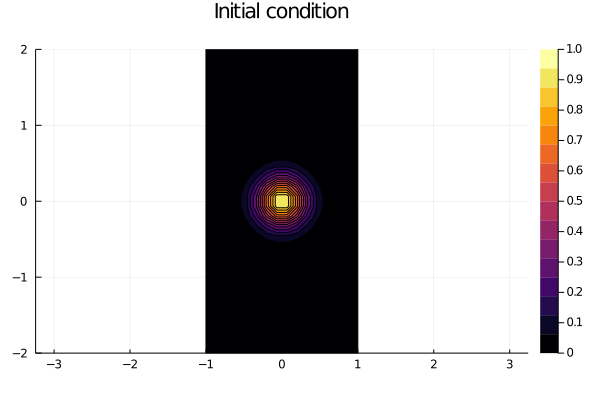

In [18]:
#prob_test.model.u0
contourf(grid_test.xRange, grid_test.yRange, prob_test.model.u0, 
         aspect_ratio=:equal, title="Initial condition", clim=(0,1))

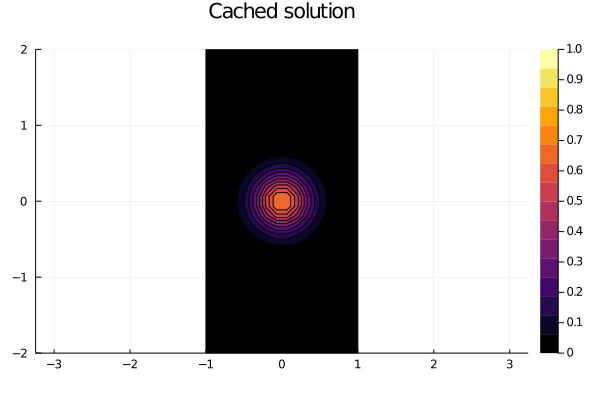

In [19]:
#prob_test.cache.u
contourf(grid_test.xRange, grid_test.yRange, prob_test.cache.u, 
         aspect_ratio=:equal, title="Cached solution", clim=(0,1))

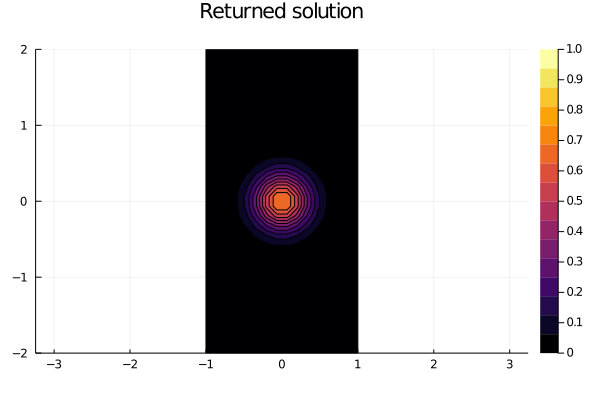

In [20]:
#sol_test.u
contourf(grid_test.xRange, grid_test.yRange, sol_test.u, 
         aspect_ratio=:equal, title="Returned solution", clim=(0,1))

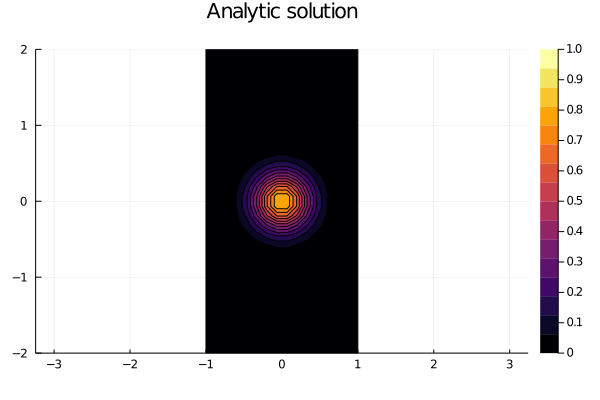

In [21]:
#sol_test.u_analytic
contourf(grid_test.xRange, grid_test.yRange, sol_test.u_analytic, 
         aspect_ratio=:equal, title="Analytic solution", clim=(0,1))

Max error: 0.11266780214008798


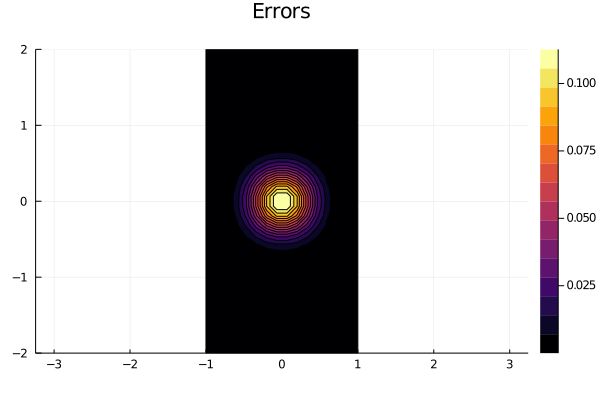

In [22]:
#sol_test.errors
println("Max error: ", maximum(sol_test.errors))
contourf(grid_test.xRange, grid_test.yRange, sol_test.errors, 
         aspect_ratio=:equal, title="Errors")

## Work precision set

In [60]:
function error_vary_params(σ, nx, ny)
    grid_σ = Grid(1., 2., nx, ny)
    param_σ = Parameters(0.2, σ, (0.0, 0.02))
    u0_σ = make_gaussian(grid_σ)
    uana_test(t) = solution_gaussian(grid_σ, t, param_σ.ν)

    mod_σ = DiffusionModel(u0_σ, uana_test, grid_σ, param_σ)
    prob_σ = DiffusionProblem(mod_σ, ExplicitDiffusion())
    
    sol_timed = @timed solve(prob_σ);
    sol_σ = sol_timed[1]
    sol_time = sol_timed[2]
    
    abs_err = maximum(sol_σ.errors)
    rel_err = abs_err/maximum(sol_σ.u_analytic)
    
    return sol_time, abs_err, rel_err
end;
function error_vector_σ(σ, error_fun)
    abs_errors = zeros(size(σ))
    rel_errors = zeros(size(σ))
    times = zeros(size(σ))
    for i in 1:length(abs_errors)
        println(σ[i])
        times[i], abs_errors[i], rel_errors[i] = error_fun(σ[i])
    end
    return times, abs_errors, rel_errors
end;

In [61]:
error_vary_σ_8x16(σ) = error_vary_params(σ, 8, 16)
error_vary_σ_16x32(σ) = error_vary_params(σ, 16, 32)
error_vary_σ_32x64(σ) = error_vary_params(σ, 32, 64)
timeerr_8x16  = error_vector_σ(range(1e-6, 5e-1, length = 40), error_vary_σ_8x16)
timeerr_16x32 = error_vector_σ(range(1e-6, 5e-1, length = 40), error_vary_σ_16x32)
timeerr_32x64 = error_vector_σ(range(1e-6, 5e-1, length = 40), error_vary_σ_32x64);

1.0e-6
0.01282148717948718
0.02564197435897436
0.038462461538461536
0.051282948717948716
0.0641034358974359
0.07692392307692307
0.08974441025641025
0.10256489743589743
0.11538538461538461
0.1282058717948718
0.14102635897435897
0.15384684615384617
0.16666733333333333
0.1794878205128205
0.1923083076923077
0.20512879487179486
0.21794928205128206
0.23076976923076922
0.24359025641025642
0.2564107435897436
0.2692312307692308
0.282051717948718
0.2948722051282051
0.3076926923076923
0.3205131794871795
0.33333366666666664
0.34615415384615383
0.35897464102564103
0.3717951282051282
0.38461561538461536
0.39743610256410256
0.41025658974358975
0.42307707692307694
0.4358975641025641
0.4487180512820513
0.4615385384615385
0.47435902564102567
0.4871795128205128
0.5
1.0e-6
0.01282148717948718
0.02564197435897436
0.038462461538461536
0.051282948717948716
0.0641034358974359
0.07692392307692307
0.08974441025641025
0.10256489743589743
0.11538538461538461
0.1282058717948718
0.14102635897435897
0.15384684615384

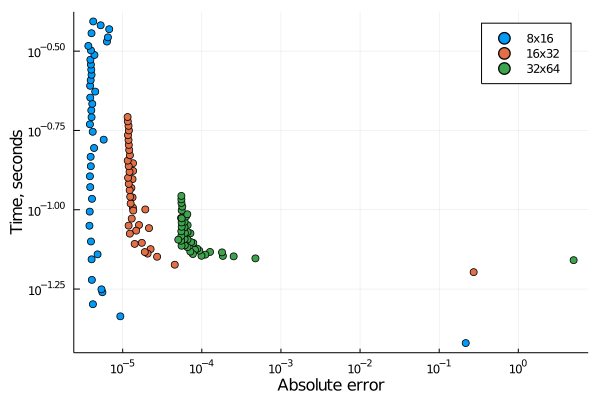

In [62]:
scatter(timeerr_8x16[1], timeerr_8x16[2],
        xaxis = :log10, yaxis = :log10,
        label = "8x16",
        xlabel = "Absolute error",
        ylabel = "Time, seconds")
scatter!(timeerr_16x32[1], timeerr_16x32[3],
        label = "16x32")
scatter!(timeerr_32x64[1], timeerr_32x64[3],
        label = "32x64")